<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/02_backtesting_risk_management/W7_Walk_Forward_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA Trading Strategy with Walk-Forward Validation

In [1]:
!pip install backtrader
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 4.7 MB/s eta 0:00:00


In [14]:
import yfinance as yf
import backtrader as bt
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [112]:
#get data from yahoo finance
#ticker = 'SPY'
ticker = 'QQQ'
data = yf.download(ticker, start='2004-01-01', end='2024-01-01') #20 years of daily data

[*********************100%***********************]  1 of 1 completed


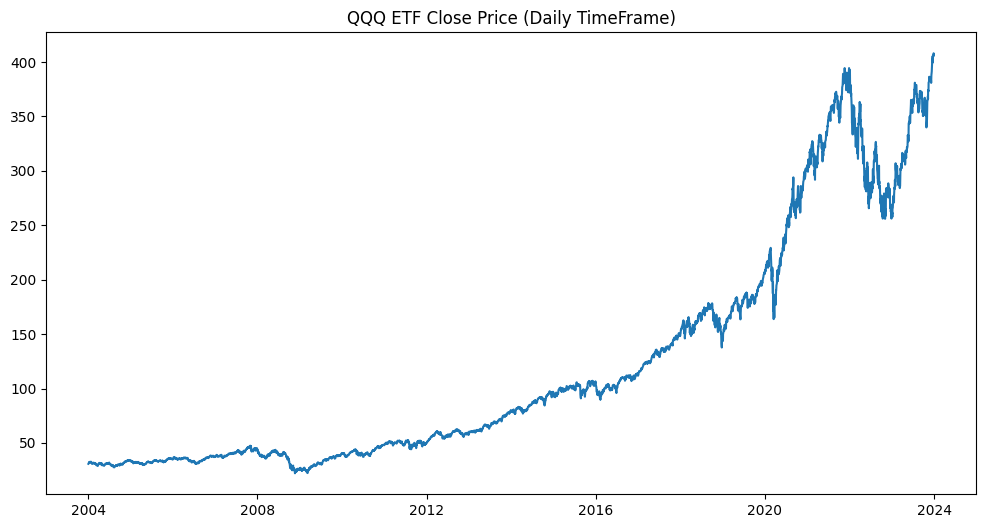

In [113]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title(f'{ticker} ETF Close Price (Daily TimeFrame)')
plt.show()

In [114]:
#rename columns and sdjust for feeding into BT
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = ['open', 'high', 'low', 'close', 'volume']
data.head()

,open,high,low,close,volume
Date,,,,,
2004-01-02,31.051914,31.162028,30.679225,30.797808,55234100
2004-01-05,30.984153,31.475425,30.967212,31.416134,69717900
2004-01-06,31.407663,31.695648,31.297549,31.627888,60033000
2004-01-07,31.577058,31.915869,31.399184,31.915869,71830000
2004-01-08,32.059854,32.186909,31.848098,32.169968,76800900


Before proceeding...

*Why we want to apply WFV*?

- Run the strategy on the test period only — but with the knowledge/indicators calculated from the training window.
- Repeat the process by moving the window forward (walk-forward).

If we dont do this, our strategy suffers data leakage as we are using data that, when trading live, we don't have.

*So?*

Indicators are calcualted on historical data and then we use these indicators on the OOS data to check the results

In [115]:
#create a bt class with long only strategy
class MAS(bt.Strategy):
  params = dict(ma_fast = 20, ma_slow = 50,train_end = None)

  def __init__(self):
    self.ma_fast = bt.indicators.SMA(self.data.close, period = self.params.ma_fast)
    self.ma_slow = bt.indicators.SMA(self.data.close, period = self.params.ma_slow)
    self.crossover = bt.indicators.CrossOver(self.ma_fast, self.ma_slow)
    #keep track of pending orders
    self.order = None

  def notify_order(self, order):
    if order.status in [order.Completed, order.Canceled, order.Margin, order.Rejected]:
        self.order = None


  def next(self):
    current_date = self.data.datetime.date(0)
    #if train_end is not None and the current date bar is <= train_end date stop trading
    # this is used to skip trading during training periods
    if self.params.train_end and current_date <= self.params.train_end:
        return
    if self.order:
      return
    if not self.position:
      if self.crossover > 0:
        self.order = self.buy()
      elif self.crossover < 0:
        self.order = self.close()


#define the WFV function
def runWFV(data, train_period_days = 365 , test_period_days = 90, initial_cash = 100000):
  #define the series of start dates... in this case (with train period of 1 year) it will be 01-01-2000, 01-01-2001, ....
  start_dates = pd.date_range(data.index.min(),data.index.max(),freq='30d')
  #store list of resutls
  results = list()

  #train-test split the data
  for start in start_dates:
    train_end = start + timedelta(days = train_period_days)
    test_end = train_end + timedelta(days = test_period_days)
    combined_data = data.loc[start:test_end]
    test_data = data.loc[train_end:test_end]

    #skip if too short
    if len(test_data) < 50:
      continue

    #set up cerebro, broker and position sizing
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MAS, train_end = train_end.date()) #pass when the train_ends to the strategy
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(commission = 0.001)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=50) #investing 50% of liquidity
    #pass data to bt
    bt_data = bt.feeds.PandasData(dataname = combined_data)
    cerebro.adddata(bt_data)
    #save the result
    result = cerebro.run()
    final_value = cerebro.broker.getvalue()
    test_return = (final_value - initial_cash) / initial_cash

    results.append({
            'Train Start': start.date(),
            'Train End': train_end.date(),
            'Test End': test_end.date(),
            'Final Portfolio Value': final_value,
            'Test Return (%)': round(test_return * 100, 2)
        })

  return pd.DataFrame(results)

In [116]:
#plotting

def plot_test_returns(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Test End'], results_df['Test Return (%)'], marker='o', linestyle='-')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title('Out-of-Sample Test Returns Over Time')
    plt.ylabel('Return (%)')
    plt.xlabel('Test End Date')
    plt.grid(True)
    plt.show()

#cumulative returns
def add_cumulative_returns(results_df):
    results_df = results_df.copy()
    #convert return (%) to cumulative product of (1 + return)
    results_df['Cumulative Return'] = (1 + results_df['Test Return (%)'] / 100).cumprod()
    return results_df

def plot_cumulative_returns(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Test End'], results_df['Cumulative Return'], marker='o')
    plt.title('Cumulative Out-of-Sample Return Over Time')
    plt.ylabel('Cumulative Return (x)')
    plt.xlabel('Test End Date')
    plt.grid(True)
    plt.show()

# rolling sharpe ration
def plot_rolling_sharpe(results_df, window=4):
    results_df = results_df.copy()
    returns = results_df['Test Return (%)'] / 100
    rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Test End'], rolling_sharpe, marker='o', label=f'{window}-period rolling Sharpe')
    plt.title(f'Rolling Sharpe Ratio (window={window})')
    plt.xlabel('Test End Date')
    plt.ylabel('Sharpe Ratio')
    plt.axhline(0, linestyle='--', color='gray')
    plt.grid(True)
    plt.legend()
    plt.show()

#distribution of returns
from scipy.stats import skew, kurtosis

def plot_test_return_distribution(results_df):
    returns = results_df['Test Return (%)']

    plt.figure(figsize=(12,6))
    plt.hist(returns, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Out-of-Sample Test Returns')
    plt.xlabel('Test Return (%)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Display skewness and kurtosis
    sk = skew(returns)
    kt = kurtosis(returns)
    plt.axvline(0, color='gray', linestyle='--')
    plt.text(0.05, 0.95, f'Skew: {sk:.2f}\nKurtosis: {kt:.2f}',
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=12)
    plt.show()



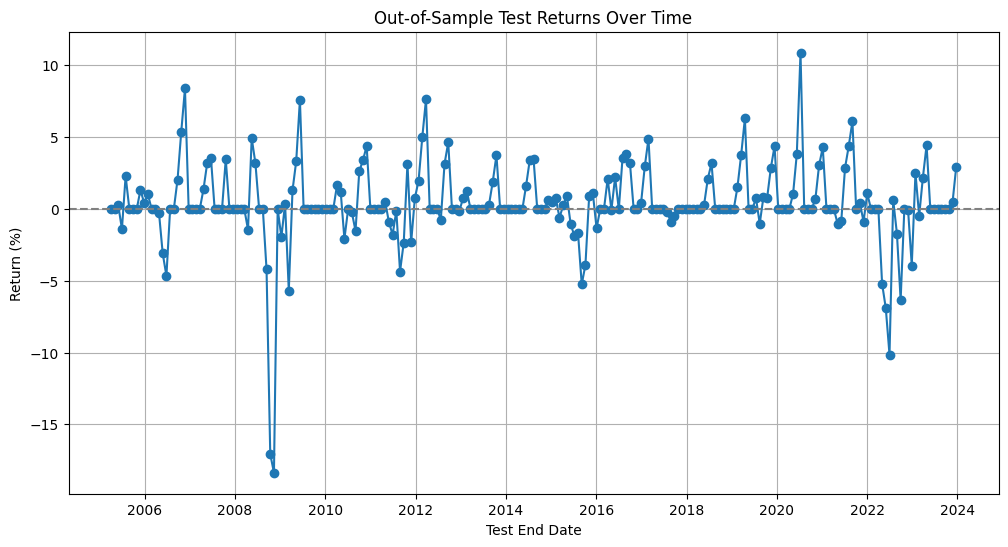

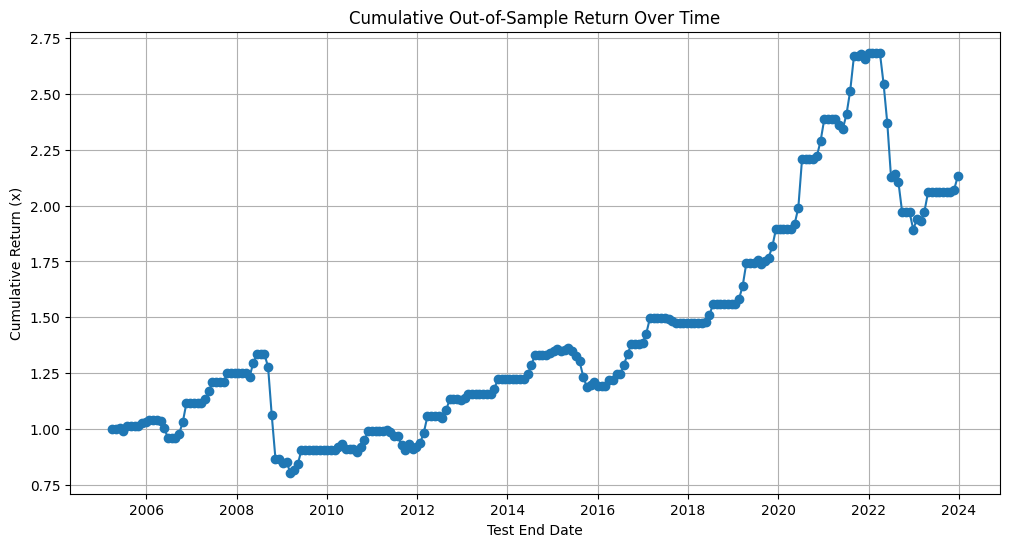

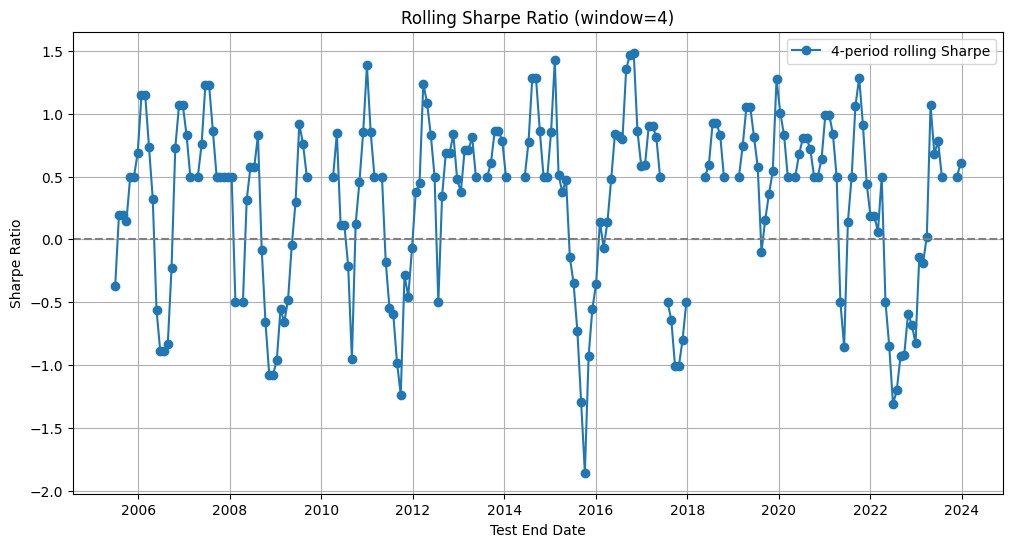

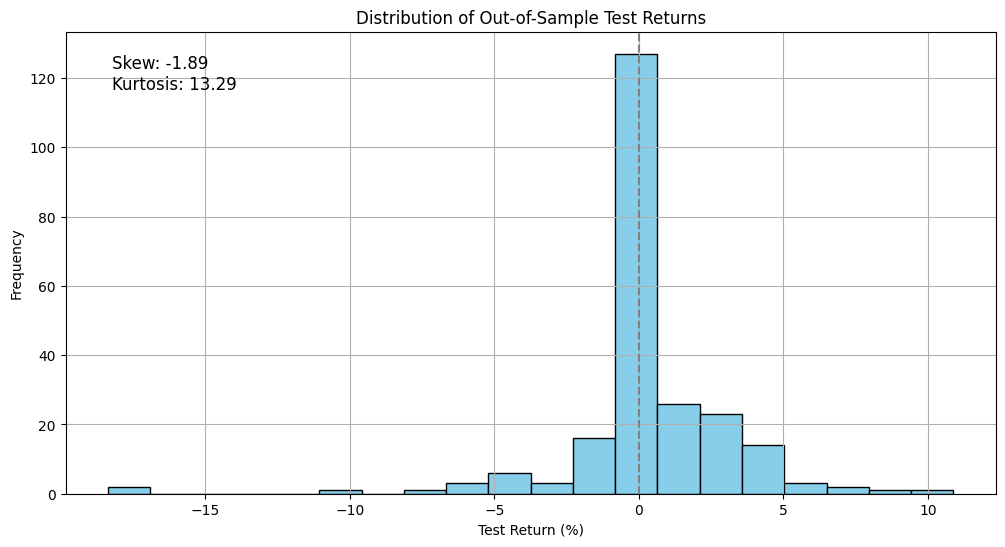

In [117]:
# Run WFV
results_df = runWFV(data)

# Add cumulative returns
results_df = add_cumulative_returns(results_df)

# Plot everything
plot_test_returns(results_df)
plot_cumulative_returns(results_df)
plot_rolling_sharpe(results_df, window=4)  # yearly Sharpe as test is 90dys so 4 windows is around 1 year
plot_test_return_distribution(results_df)
